In [9]:
import plotly.express as px
from IPython.display import display
from ingest_stocks_to_df import IngestStocks
from keras_stock_preprocessing import KerasPreprocess
from model_stock_fit import ModelFit
from visualize_stocks import VisualizeStocks
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import pandas as pd
from itertools import cycle
from keras.layers import Dense, GRU
from keras import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.preprocessing import timeseries_dataset_from_array
from keras.utils import model_to_dot, plot_model

# data

In [10]:
stocks_str = 'GSIT'##'GSIT, ICAD, XAIR, LTRN, ARKK, ARKF, ARKW'
ticker_list = [ticker.strip() for ticker in stocks_str.upper().split(',')]
time_diff_years= 1
stocks_df = IngestStocks.ingest_stocks_to_df(ticker_list=ticker_list, time_diff_years=time_diff_years)
display(stocks_df)
stock_names = ticker_list[0:3]
display(stock_names)
column_metric = 'Adj Close'

date    GSIT                                     
                         High    Low  Open Close  Volume Adj Close
Date                                                              
2020-03-02 2020-03-02  6.7400  6.550  6.67  6.68   33500      6.68
2020-03-03 2020-03-03  6.8500  6.540  6.63  6.63   46800      6.63
2020-03-04 2020-03-04  6.7700  6.570  6.63  6.73   73500      6.73
2020-03-05 2020-03-05  7.0300  6.650  6.65  6.79   31000      6.79
2020-03-06 2020-03-06  6.8200  6.560  6.72  6.65   29100      6.65
...               ...     ...    ...   ...   ...     ...       ...
2021-02-24 2021-02-24  7.7600  7.500  7.76  7.56   75600      7.56
2021-02-25 2021-02-25  7.7900  7.460  7.61  7.64  142600      7.64
2021-02-26 2021-02-26  7.7700  7.340  7.76  7.34   72700      7.34
2021-03-01 2021-03-01  7.7700  7.440  7.46  7.67  117000      7.67
2021-03-02 2021-03-02  7.7781  7.585  7.61  7.65   62559      7.65

[253 rows x 7 columns]

['GSIT']

# visualization

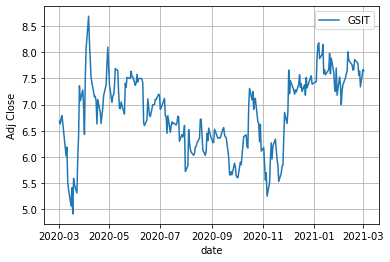

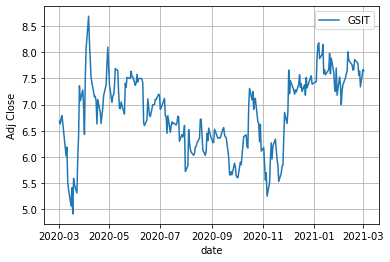

In [13]:
VisualizeStocks.add_stocks_fig(stock_names=ticker_list, column_metric=column_metric,stocks_df=stocks_df)

# fit

In [4]:
# class KerasPreprocess:
#     def __init__():
#         pass
#     @classmethod
#     def keras_batch_preprocess(cls, stocks_df, company_name, metric, lookback_length=60, batch_size=60):
#         column_list = cls.get_column_list(stocks_df, company_name, metric)
#         data, targets = cls.get_data_targets_split(column_list, lookback_length=lookback_length)
#         data_train, data_val, data_test = cls.train_val_test_split(data)
#         targets_train, targets_val, targets_test = cls.train_val_test_split(targets)
#         train_ds = timeseries_dataset_from_array(data=data_train, targets=targets_train, sequence_length=lookback_length, batch_size=batch_size)
#         val_ds = timeseries_dataset_from_array(data=data_val, targets=targets_val, sequence_length=lookback_length, batch_size=batch_size)
#         test_ds = timeseries_dataset_from_array(data=data_test, targets=targets_test, sequence_length=lookback_length, batch_size=batch_size)
#         return train_ds, val_ds, test_ds
#     @staticmethod
#     def get_column_list(stocks_df, company_name, metric):
#         column_slice = stocks_df[company_name, metric]
#         column_list = column_slice.tolist()
#         return column_list
#     @staticmethod
#     def get_data_targets_split(column_list, lookback_length=20):
#         data = np.array([[x] for x in column_list[:-lookback_length]])
#         targets = np.array([y for y in column_list[lookback_length:]])
#         return data, targets
#     @staticmethod
#     def train_val_test_split(data, test_size=0.2):
#         test_length = int(len(data)*test_size)
#         train_length = 1 - 2*test_length
#         train = data[:train_length]
#         val = data[train_length:train_length+test_length]
#         test = data[-test_length:]
#         return train, val, test

# class PreprocessingXY:    
#     @classmethod
#     def preprocess(cls, stocks_df, company_name, metric, lookback_length=60):
#         column_list = cls.get_column_list(stocks_df, company_name, metric)
#         x, y = cls.to_xy_timeseries(column_list, lookback_length=lookback_length)
#         x_train, x_test, y_train, y_test = cls.xy_train_test_split(x, y, test_size=0.2)
#         x_train, x_test, y_train, y_test = [cls.batch_reshape(d) for d in [x_train, x_test, y_train, y_test]]
#         return x_train, x_test, y_train, y_test
#     @staticmethod
#     def get_column_list(stocks_df, company_name, metric):
#         column_slice = stocks_df[company_name, metric]
#         column_list = column_slice.tolist()
#         return column_list
#     @staticmethod
#     def to_xy_timeseries(column_list, lookback_length=60):
#         x, y = list(),list()
#         for index in range(lookback_length, len(column_list)):
#             x.append(column_list[index-lookback_length:index])
#             y.append(column_list[index])
#         x = np.array(x)
#         y = np.array(y)
#         return x, y
#     @classmethod
#     def xy_train_val_test_split(cls, x, y, test_size=0.2, lookback_length=60):
#         x_train, x_val, x_test = cls.train_val_test_split(x, test_size=test_size)
#         y_train, y_val, y_test = cls.train_val_test_split(y, test_size=test_size)
#         timeseries_dataset_from_array(x=x_train, y=y_train)
#         return
#     @staticmethod
#     def train_test_split(data, test_size=0.2):
#         test_length = int(len(data)*test_size)
#         train_length = 1 - test_length
#         train = data[:train_length]
#         test = data[-test_length:]
#         return train, test
#     @classmethod
#     def xy_train_test_split(cls,x, y, test_size=0.2):
#         x_train, x_test = cls.train_test_split(x, test_size=test_size)
#         y_train, y_test = cls.train_test_split(y, test_size=test_size)
#         return x_train, x_test, y_train, y_test
#     @staticmethod
#     def batch_reshape(np_array):
#         reshaped = np_array.reshape(1, *np_array.shape)
#         return reshaped

In [5]:
# class ModelFit:
#     def __init__(self):
#         pass
#     @staticmethod
#     def gru_model(nodes=50, dropout=0.0, recurrent_dropout=0.0, learning_rate=0.01, loss='mse', optimizer=Adam, metrics=['mse']):
#         model = Sequential()
#         model.add(GRU(nodes))
#         model.add(Dense(1, activation='linear'))
#         model.compile(optimizer=optimizer(learning_rate=learning_rate),
#                   loss=loss,
#                   metrics=metrics)
#         return model
#     @classmethod
#     def train_model(cls, train_data=None, validation_data=None, model=None):
#         early_stop = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
#         model = cls.gru_model()
#         history = model.fit(train_data, validation_data=validation_data, callbacks=[early_stop], epochs=300)
#         return history, model
#     @staticmethod
#     def evaluate_model(model,test_data):
#         model.evaluate(test_data)

In [6]:
metric = 'Adj Close'
company_name = 'GSIT'
lookback_length=40
batch_size=30

train_ds, val_ds, test_ds = KerasPreprocess.keras_batch_preprocess(stocks_df, company_name, metric, lookback_length=lookback_length, batch_size=batch_size)

mf = ModelFit
model=mf.gru_model()
history, model = mf.train_model(train_data=train_ds, validation_data=val_ds, model=model)

test_error = mf.evaluate_model(model, test_ds)

train_error = pd.DataFrame(history.history)
display(train_error)

TypeError: object of type 'NoneType' has no len()

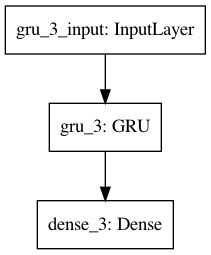

In [16]:
plot_model(model, expand_nested=True)